In [1]:
import optiland.backend as be
from optiland.optic import Optic
from optiland.rays import RealRays
from optiland.materials import Material, IdealMaterial
from optiland.physical_apertures import RadialAperture, RectangularAperture

In [2]:
be.set_backend('torch')
be.grad_mode.enable()
be.set_device('cpu')
be.set_precision('float64')

In [3]:
# --- Create the optical system ---
class System(Optic):
    """We can define our optical system here, and can be called from other scripts"""

    def __init__(self):
        super().__init__()

        # System Settings (Wvls, aperture, etc)
        ## ---- Aperture ----
        self.set_aperture(aperture_type="EPD", value=4.0)

        ## ---- Fields ----
        self.set_field_type(field_type="angle")
        self.add_field(y=0)

        ## ---- Wavelengths ----
        # self.add_wavelength(value=1.53)
        self.add_wavelength(value=1.550, is_primary=True)
        # self.add_wavelength(value=1.56)

        # Materials to be used
        H_K3 = Material("H-K3", reference='cdgm')
        H_ZLAF68C = Material("H-ZLAF68C", reference='cdgm')

        # -- Lens Data Editor here --

        ## LDE Auxiliary data
        
        coeffs_S2 = [1.614, 0.348]#, 0.150, 0.033]
        forbes_coeffs_n_S2 = [(n, 0) for n in range(len(coeffs_S2))]
        norm_radius_S2 = 6.336
        conic_S2 = -4.428
        coeffs_S4 = [-0.270, 0.087]#, -0.048, 0.026]
        forbes_coeffs_n_S4 = [(n, 0) for n in range(len(coeffs_S4))]
        conic_S4 = 0.038
        norm_radius_S4 = 10.0        

        
        
        ap1 = RadialAperture(5)
        ap2 = RadialAperture(10.5)
        apt_detector = RectangularAperture(-20, 20, -20, 20)

        self.add_surface(index=0, thickness=be.inf)
        self.add_surface(index=1, thickness=26.5)
        self.add_surface(index=2, thickness=4.0, radius=be.inf, material=H_K3, is_stop=True)
        self.add_surface(index=3, thickness=25.0, radius=22.0, conic=conic_S2, forbes_coeffs_n=forbes_coeffs_n_S2, forbes_coeffs_c=coeffs_S2, forbes_norm_radius=norm_radius_S2, surface_type="forbes_qbfs") 
        self.add_surface(index=4, thickness=7.0, radius=be.inf, material=H_ZLAF68C)
        self.add_surface(index=5, thickness=10.0, radius=-31.0, conic=conic_S4, forbes_coeffs_n=forbes_coeffs_n_S4, forbes_coeffs_c=coeffs_S4, forbes_norm_radius=norm_radius_S4, surface_type="forbes_qbfs")
        self.add_surface(index=6, aperture=apt_detector)
        # self.add_surface(index=6)  # image

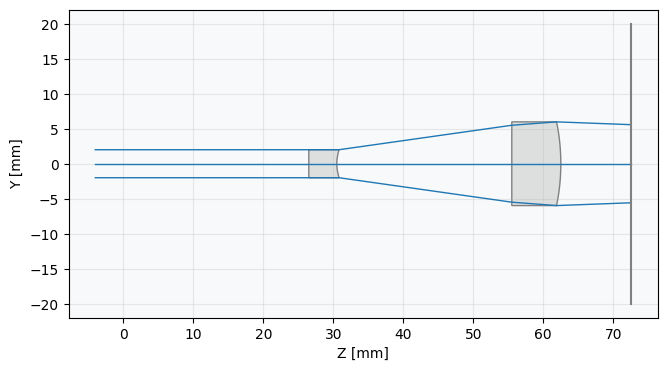

In [4]:
lens = System()
lens.draw(num_rays=3)

In [5]:
test_rays = RealRays(
            x=be.array([0.0, 0.0, 0.0]),
            y=be.array([-2.0, 0.0, 2.0]),
            z=be.array([0.0, 0.0, 0.0]),
            L=be.array([0.0, 0.0, 0.0]),
            M=be.array([0.0, 0.0, 0.0]),
            N=be.array([1.0, 1.0, 1.0]),
            wavelength=be.ones(3)*1.550,
            intensity=be.ones(3)
        )

In [6]:
rays_out = lens.surface_group.trace(test_rays)
print("Rays after tracing through the system:")
print(rays_out)

Rays after tracing through the system:
 Ray # |          x |          y |          z |          L |          M |          N |  Intensity |   Wavelength
----------------------------------------------------------------------------------------------------------------------
     0 |     0.0000 |    -5.5800 |    72.5000 |   0.000000 |   0.037606 |   0.999293 |     0.9936 |       1.5500
     1 |     0.0000 |     0.0000 |    72.5000 |  -0.000000 |  -0.000000 |   1.000000 |     0.9938 |       1.5500
     2 |     0.0000 |     5.5800 |    72.5000 |   0.000000 |  -0.037606 |   0.999293 |     0.9936 |       1.5500
----------------------------------------------------------------------------------------------------------------------
Showing 3 of 3 rays.



In [7]:
import torch, optiland.backend as be
from optiland.geometries.forbes.qpoly import compute_z_zprime_Q2d

be.set_backend("torch")

cm0 = torch.tensor([1.0, 0.1, 0.01], dtype=torch.float64, requires_grad=True)
u    = torch.tensor([0.2, 0.37], dtype=torch.float64)
theta= torch.tensor([0.0, 1.0], dtype=torch.float64)

z, *_ = compute_z_zprime_Q2d(cm0, [], [], u, theta)
(z.sum()).backward()
print("∂z/∂cm0 =", cm0.grad)        # non-zero ⇒ gradients OK

∂z/∂cm0 = tensor([2.0000, 5.3155, 6.0731], dtype=torch.float64)


In [8]:
import torch
import optiland.backend as be
from optiland.optic.optic import Optic
from optiland.geometries.forbes.qpoly import compute_z_zprime_Q2d

# ------------------------------------------------------------------
# 1.  Tiny Forbes surface inside an Optic
# ------------------------------------------------------------------
be.set_backend("torch")

lens = Optic()
lens.set_aperture(aperture_type="EPD", value=4.0)
lens.set_field_type(field_type="angle")
lens.add_field(y=0)
lens.add_wavelength(value=1.55, is_primary=True)

# One Forbes surface, single cm0 coefficient (M = 0) so we stress
# exactly the code path that used to fail.
cm0 = torch.tensor([0.25], dtype=torch.float64, requires_grad=True)

lens.add_surface(index=0, thickness=0.0)           # object
lens.add_surface(index=1, thickness=50.0,          # Forbes surface
                 radius=100.0,
                 surface_type="forbes_qbfs",
                 forbes_coeffs_n=[(0, 0)],         # m = 0 term only
                 forbes_coeffs_c=cm0)
lens.add_surface(index=2)                          # image

# ------------------------------------------------------------------
# 2.  Trace one on-axis ray & define a dummy loss
# ------------------------------------------------------------------
rays_out = lens.surface_group.trace(test_rays)

# Loss = square of y-coordinate in image plane
loss = (rays_out.y ** 2).sum()

# ------------------------------------------------------------------
# 3.  Back-propagate
# ------------------------------------------------------------------
loss.backward()

print(f"loss value        : {loss.item():.6f}")
print(f"d(loss)/d(cm0)[0] : {cm0.grad.item():.6e}")
assert torch.isfinite(cm0.grad).all() and cm0.grad.abs().max() > 0, \
       "Gradient vanished or became NaN/Inf"

print("✓ autodiff path through Forbes sag & ray-trace is intact.")


loss value        : 82.605678
d(loss)/d(cm0)[0] : 2.606876e-48
✓ autodiff path through Forbes sag & ray-trace is intact.


In [9]:
# --- Test for Automatic Differentiation ---
# This cell checks if gradients are flowing correctly back to the Forbes coefficients.

# 1. Ensure the PyTorch backend is active and enable gradient tracking
import optiland.backend as be
from optiland.rays import RealRays

# It's good practice to re-run this in the test cell to be explicit
be.set_backend('torch')
be.set_device('cpu') 
be.set_precision('float64')
be.grad_mode.enable()

# 2. Re-create the optical system
# We create a new instance to ensure parameters are fresh tensors for this test
lens_for_grad_test = System()

# 3. Get the specific Forbes surface and its coefficients
# Let's test the gradient with respect to the coefficients of the first Forbes surface (index 3)
forbes_surface = lens_for_grad_test.surface_group.surfaces[3].geometry
coeffs_to_test = forbes_surface.coeffs_c

# IMPORTANT: Explicitly tell PyTorch to track gradients for this parameter tensor
coeffs_to_test.requires_grad_(True)

# 4. Create a single test ray
# We only need one ray to check the gradient path
ray = RealRays(
    x=be.array([0.0]),
    y=be.array([1.0]), # A non-zero y-coordinate
    z=be.array([0.0]),
    L=be.array([0.0]),
    M=be.array([0.0]),
    N=be.array([1.0]),
    wavelength=be.array([1.550]),
    intensity=be.array([1.0])
)

# 5. Trace the ray through the system
# We must zero out any existing gradients before backpropagation
if coeffs_to_test.grad is not None:
    coeffs_to_test.grad.zero_()

rays_out = lens_for_grad_test.surface_group.trace(ray)

# 6. Define a simple scalar "loss" function from the output
# The loss can be any differentiable operation that results in a single number.
# The sum of the final y-coordinates is a standard choice.
loss = be.sum(rays_out.y)

# 7. Perform backpropagation
# This is where PyTorch calculates the gradients
loss.backward()

# 8. Check the .grad attribute of our coefficient tensor
gradient = coeffs_to_test.grad

print("--- Autodiff Test Results ---")
print(f"Computed gradient: {gradient}")

if gradient is not None and be.any(gradient != 0):
    print("\n\033[92mSUCCESS: Automatic differentiation is WORKING.\033[0m")
    print("Gradients are flowing back to the Forbes coefficients.")
else:
    print("\n\033[91mERROR: Automatic differentiation is BROKEN.\033[0m")
    print("Gradients are `None` or all zeros, indicating the computation graph was severed.")

# --- Cleanup ---
# It's good practice to disable grad mode if other cells don't need it
be.grad_mode.disable()


--- Autodiff Test Results ---
Computed gradient: tensor([0.7072, 1.9781], dtype=torch.float64)

SUCCESS: Automatic differentiation is WORKING.
Gradients are flowing back to the Forbes coefficients.


In [3]:
# --- Create the optical system ---
class System2(Optic):
    """We can define our optical system here, and can be called from other scripts"""

    def __init__(self):
        super().__init__()

        self.set_aperture(aperture_type="EPD", value=4.0)

        self.set_field_type(field_type="angle")
        self.add_field(y=0)

        self.add_wavelength(value=1.550, is_primary=True)

        #H_K3 = Material("H-K3", reference='cdgm')
        H_K3 = IdealMaterial(n=1.50, k=0)
        H_ZLAF68C = Material("H-ZLAF68C", reference='cdgm')



        # a(1,1) -> optiland tuple (1, 1)
        # b(1,1) -> optiland tuple (1, -1)


        coeffs_S2 = [1.0, 0.5]
        forbes_coeffs_n_S2 = [(0,1), (0,-1)]  
        norm_radius_S2 = 6.0
        conic_S2 = -4.428
        coeffs_S4 = [-0.334, 0.130, -0.099, 0.082, -0.093]
        forbes_coeffs_n_S4 = [(n, 0) for n in range(len(coeffs_S4))]
        conic_S4 = 0.038
        norm_radius_S4 = 10.0        

        ap1 = RadialAperture(5)
        ap2 = RadialAperture(10.5)
        apt_detector = RectangularAperture(-20, 20, -20, 20)

        self.add_surface(index=0, thickness=be.inf)
        self.add_surface(index=1, thickness=26.5)
        self.add_surface(index=2, thickness=4.0, radius=be.inf, material=H_K3, is_stop=True)
        self.add_surface(index=3, thickness=25.0, radius=21.709, conic=conic_S2, forbes_coeffs_n=forbes_coeffs_n_S2, forbes_coeffs_c=coeffs_S2, forbes_norm_radius=norm_radius_S2, surface_type="forbes_q2d") 
        self.add_surface(index=4, thickness=7.0, radius=be.inf, material=H_ZLAF68C)
        self.add_surface(index=5, thickness=10.0, radius=-31.408, conic=conic_S4, forbes_coeffs_n=forbes_coeffs_n_S4, forbes_coeffs_c=coeffs_S4, forbes_norm_radius=norm_radius_S4, surface_type="forbes_qbfs")
        self.add_surface(index=6, aperture=apt_detector)
        

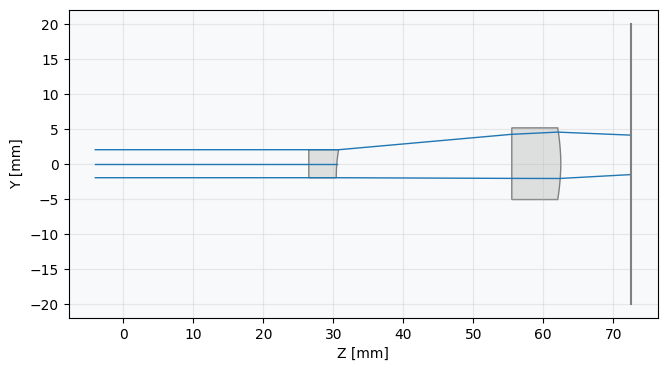

In [4]:
lens2 = System2()
lens2.draw(num_rays=3)
#lens2.draw3D(num_rays=15)

In [5]:
test_rays2 = RealRays(
            x=be.array([-2.0, 0.0, 2.0]),
            y=be.array([0.0, 0.0, 0.0]),
            z=be.array([0.0, 0.0, 0.0]),
            L=be.array([0.0, 0.0, 0.0]),
            M=be.array([0.0, 0.0, 0.0]),
            N=be.array([1.0, 1.0, 1.0]),
            wavelength=be.ones(3)*1.550,
            intensity=be.ones(3)
        )

In [6]:
sag_xy = lens2.surface_group.surfaces[3].geometry.sag(x=0.5, y=1.0)
print(f"Sag at (0.5, 1.0): {sag_xy:.5e}")
# 1.121671341074459E-001
# 1.336938133691347E-001
# 2.009377910786651E-001
# 1.956099112297364E-001

Sag at (0.5, 1.0): 1.95391e-01


In [7]:
rays_out2 = lens2.surface_group.trace(test_rays2)
print("Rays after tracing through the system:")
print(rays_out2)
# sag at (0.5, 1.0): 1.121671341074459E-001
# REAX
# 5.336801954542238E+000
# 2.542670611443687E+000
# -1.689927705492413E-001
# ----
# REAA
# 6.959385383352434E-002
# 1.231093639787748E-002
# -3.753389993612571E-002

Rays after tracing through the system:
 Ray # |          x |          y |          z |          L |          M |          N |  Intensity |   Wavelength
----------------------------------------------------------------------------------------------------------------------
     0 |    -0.2131 |     1.2295 |    72.5000 |   0.067725 |   0.001547 |   0.997703 |     0.9986 |       1.5500
     1 |        nan |        nan |        nan |        nan |        nan |        nan |     0.0000 |       1.5500
     2 |     5.3094 |     1.2741 |    72.5000 |  -0.037995 |   0.006877 |   0.999254 |     0.9987 |       1.5500
----------------------------------------------------------------------------------------------------------------------
Showing 3 of 3 rays.



autodiff test for q-2d

In [8]:
import torch
torch.autograd.set_detect_anomaly(True)

coeffs_to_test = be.array([1.0, 0.5])

# 4. Instantiate the optical system, passing in our tensor
lens_for_grad_test = System2()

# 5. Create a single off-axis test ray to check the gradient path
ray = RealRays(
    x=be.array([0.0]),
    y=be.array([1.0]), # A non-zero y-coordinate is crucial for testing asymmetric terms
    z=be.array([0.0]),
    L=be.array([0.0]),
    M=be.array([0.0]),
    N=be.array([1.0]),
    wavelength=be.array([1.550]),
    intensity=be.array([1.0])
)

# 6. Trace the ray through the system
# We must zero out any existing gradients before backpropagation
if coeffs_to_test.grad is not None:
    coeffs_to_test.grad.zero_()

rays_out = lens_for_grad_test.surface_group.trace(ray)

# 7. Define a simple scalar "loss" function from the output
# The sum of the final y-coordinates is a standard choice.
loss = be.sum(rays_out.y)

# 8. Perform backpropagation to calculate gradients
loss.backward()

# 9. Check the .grad attribute of our coefficient tensor
gradient = coeffs_to_test.grad

print("--- Q-2D Autodiff Test Results ---")
print(f"Coefficients under test: {coeffs_to_test.data}")
print("--- Autodiff Test Results ---")
print(f"Computed gradient: {gradient}")

if gradient is not None and be.any(gradient != 0):
    print("\n\033[92mSUCCESS: Automatic differentiation is WORKING.\033[0m")
    print("Gradients are flowing back to the Forbes coefficients.")
else:
    print("\n\033[91mERROR: Automatic differentiation is BROKEN.\033[0m")
    print("Gradients are `None` or all zeros, indicating the computation graph was severed.")

# --- Cleanup ---
# It's good practice to disable grad mode if other cells don't need it
# And turn off anomaly detection.
torch.autograd.set_detect_anomaly(False)

--- Q-2D Autodiff Test Results ---
Coefficients under test: tensor([1.0000, 0.5000], dtype=torch.float64)
--- Autodiff Test Results ---
Computed gradient: None

ERROR: Automatic differentiation is BROKEN.
Gradients are `None` or all zeros, indicating the computation graph was severed.


In [15]:
import optiland.backend as be
# The sag calculation relies on these helpers from your existing qpoly.py file
from optiland.geometries.forbes.qpoly import Q2d_nm_c_to_a_b, compute_z_zprime_Q2d


def check_forbes_sag(x, y, radius, conic, norm_radius, coeffs_n, coeffs_c):
    """
    Calculates the sag of a Forbes Q-2D surface at a given point (x, y).

    This function is isolated from the main Optic/Surface class structure and
    is intended for direct verification of the surface shape.

    Args:
        x (float or array-like): The x-coordinate(s) of the point(s) to check.
        y (float or array-like): The y-coordinate(s) of the point(s) to check.
        radius (float): The base radius of curvature of the surface.
        conic (float): The conic constant of the surface.
        norm_radius (float): The normalization radius for the Forbes polynomials.
        coeffs_n (list of tuples): List of (n, m) indices for the coefficients.
        coeffs_c (list of floats): List of coefficient values corresponding to coeffs_n.

    Returns:
        float or array-like: The calculated sag (z-coordinate) of the surface.
    """
    # 1. Prepare inputs and basic parameters
    # Ensure inputs are backend arrays for vectorized calculations
    x = be.array(x)
    y = be.array(y)
    
    # Basic geometric calculations
    r2 = x**2 + y**2
    rho = be.sqrt(r2)
    c = 1 / radius if radius != 0 else 0
    u = rho / norm_radius
    usq = u * u
    theta = be.arctan2(y, x)

    # 2. Calculate the base conic sag
    if be.isinf(radius) or radius == 0:
        z_base = be.zeros_like(r2)
    else:
        sqrt_arg = 1 - (1 + conic) * c**2 * r2
        # Use be.where for safe sqrt on arrays
        safe_sqrt_arg = be.where(sqrt_arg >= 0, be.sqrt(sqrt_arg), 1.0)
        z_base = c * r2 / (1 + safe_sqrt_arg)

    # 3. Prepare Forbes coefficients
    # This structure is needed for the polynomial computation engine
    cm0, ams, bms = Q2d_nm_c_to_a_b(coeffs_n, coeffs_c)

    # 4. Compute the raw polynomial sum part of the departure
    poly_sum_m0, _, poly_sum_m_gt0, _, _ = compute_z_zprime_Q2d(
        cm0, ams, bms, u, theta
    )

    # 5. Calculate the full departure terms, applying necessary factors
    
    # --- m=0 Departure Term (Q-BFS part) ---
    departure_m0 = be.zeros_like(rho)
    # Check if there are any m=0 coefficients to process
    has_m0_coeffs = cm0 is not None and len(cm0) > 0 and be.any(be.array(cm0) != 0)
    
    if has_m0_coeffs:
        prefactor = usq * (1 - usq)
        
        if be.isinf(radius):
            conic_correction_factor = 1.0
        else:
            sqrt_arg_num = 1 - c**2 * conic * r2
            sqrt_arg_den = 1 - c**2 * (conic + 1) * r2
            safe_sqrt_num = be.sqrt(be.where(sqrt_arg_num >= 0, sqrt_arg_num, 0.0))
            safe_sqrt_den = be.sqrt(be.where(sqrt_arg_den > 0, sqrt_arg_den, 1e-12))
            conic_correction_factor = safe_sqrt_num / safe_sqrt_den
        
        departure_m0 = prefactor * conic_correction_factor * poly_sum_m0

    # --- m>0 Departure Term (Q-2D specific part) ---
    departure_m_gt0 = poly_sum_m_gt0
    
    # --- Total Departure ---
    total_departure = departure_m0 + departure_m_gt0
    
    # The departure is only defined for u <= 1
    final_departure = be.where(u > 1, 0.0, total_departure)
    
    # 6. Final sag is the sum of the base and the departure
    final_sag = z_base + final_departure

    # If the input was a scalar, return a scalar for cleaner output
    if isinstance(x, (int, float)) and hasattr(final_sag, 'item'):
        return final_sag.item()
        
    return final_sag

In [16]:
# Make sure the backend is set as you need it
# be.set_backend('torch') 

# --- Define surface parameters from your System2 class for surface #3 ---
radius_S3 = 21.709
conic_S3 = -4.428
coeffs_c_S3 = [1.0, 0.0]
coeffs_n_S3 = [(0,1), (0,2)]
norm_radius_S3 = 6.0

# --- Define the point to check ---
x_point = 0.5
y_point = 1.0

# --- Call the test function ---
sag_value = check_forbes_sag(
    x=x_point,
    y=y_point,
    radius=radius_S3,
    conic=conic_S3,
    norm_radius=norm_radius_S3,
    coeffs_n=coeffs_n_S3,
    coeffs_c=coeffs_c_S3
)

print(f"Sag of Q-2D surface at ({x_point}, {y_point}) is: {sag_value}")

Sag of Q-2D surface at (0.5, 1.0) is: 0.112058090741161


In [17]:
1.121671341074459E-001

0.1121671341074459